In [1]:
# Load packages
import numpy as np, sys
from scipy import ndimage, interpolate
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, '../saxstats/')

In [ ]:
# Load denss
import saxstats
DENSS_GPU=False

In [821]:
# Apo density - not changing
rho_apo, side = saxstats.read_mrc('2cm7_apo.mrc')

# Ligand density - ground truth
rho_ligand, side = saxstats.read_mrc('2cm7_ligand.mrc')

# Naive mask
rho_mask, side = saxstats.read_mrc('2cm7_ligand.mrc')
ligand_ref = rho_mask > 0
kernel = ndimage.generate_binary_structure(3, 2)
lig_mask = ndimage.binary_dilation(ligand_ref, structure=kernel)

# Actual mask that's from excluding apo density
rho_mask, side = saxstats.read_mrc('junk_mask.mrc')
lig_mask = rho_mask > 0

# Data
q, I, sigq, Ifit, file_dmax, isfit = saxstats.loadProfile('2cm7.dat', units='A')

dmax = 36
oversampling = 3
voxel = 0.5
D = dmax

#Initialize variables
side = oversampling*D
halfside = side/2

n = int(side/voxel)
print(n)
#want n to be even for speed/memory optimization with the FFT, ideally a power of 2, but wont enforce that
if n%2==1:
    n += 1
#store n for later use if needed
nbox = n

dx = side/n
dV = dx**3
V = side**3
x_ = np.linspace(-halfside,halfside,n)
x,y,z = np.meshgrid(x_,x_,x_,indexing='ij')
r = np.sqrt(x**2 + y**2 + z**2)
rho_apo *= dV
rho_ligand *= dV

216


In [822]:
apo_ne = np.sum(rho_apo)
print(apo_ne)
lig_ne = np.sum(rho_ligand)
print(lig_ne)
all_ne = apo_ne + lig_ne

15994.002
230.0


In [842]:
df = 1/side
qx_ = np.fft.fftfreq(x_.size)*n*df*2*np.pi
#print(qx_, np.fft.fftshift(qx_))
qx, qy, qz = np.meshgrid(qx_,qx_,qx_,indexing='ij')
qr = np.sqrt(qx**2+qy**2+qz**2)
qmax = np.max(qr)
qstep = np.min(qr[qr>0]) - 1e-8 #subtract a tiny bit to deal with floating point error
nbins = int(qmax/qstep)
qbins = np.linspace(0,nbins*qstep,nbins+1)
#create modified qbins and put qbins in center of bin rather than at left edge of bin.
qbinsc = np.copy(qbins)
qbinsc[1:] += qstep/2.
#create an array labeling each voxel according to which qbin it belongs
qbin_labels = np.searchsorted(qbins,qr,"right")
qbin_labels -= 1
#allow for any range of q data
qdata = qbinsc[np.where( (qbinsc>=q.min()) & (qbinsc<=q.max()) )]
Idata = np.interp(qdata,q,I)

qextend = qbinsc[qbinsc>=qdata.max()]
Iextend = qextend**-4
Iextend = Iextend/Iextend[0] * Idata[-1]
qdata = np.concatenate((qdata,qextend[1:]))
Idata = np.concatenate((Idata,Iextend[1:]))

#create list of qbin indices just in region of data for later F scaling
qbin_args = np.in1d(qbinsc,qdata,assume_unique=True)
qba = np.copy(qbin_args) #just for brevity when using it later
sigqdata = np.interp(qdata,q,sigq)


In [824]:
Idata.shape

(107,)

In [825]:
scale_factor = all_ne**2 / Idata[0]
Idata *= scale_factor
sigqdata *= scale_factor
I *= scale_factor
sigq *= scale_factor

Text(0, 0.5, 'Intensity')

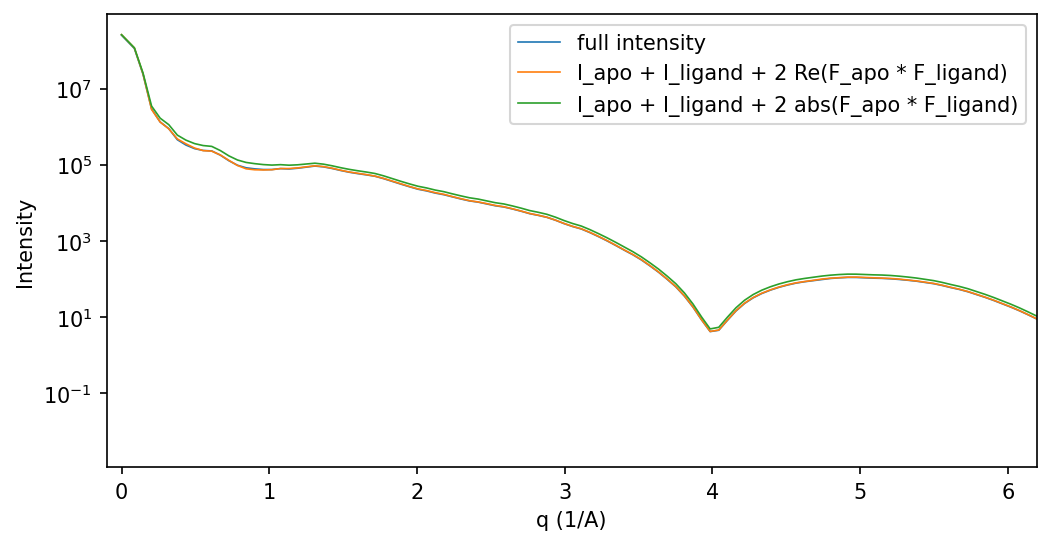

In [843]:
## Try out different ways of data fitting
rho_apo_ = np.fft.fftn(rho_apo)
rho_ligand_ = np.fft.fftn(rho_ligand)

I3D_full_ = np.abs(rho_apo_ + rho_ligand) ** 2
I3D_apo_ = np.abs(rho_apo_) ** 2
I3D_ligand_ = np.abs(rho_ligand_) ** 2
I3D_cross_w_  = np.abs(rho_apo_.conjugate() * rho_ligand_) * 2
I3D_cross_ = (rho_apo_.conjugate() * rho_ligand_).real * 2
Imean_full_ = saxstats.mybinmean(I3D_full_, qbin_labels, DENSS_GPU)
Imean_apo_ = saxstats.mybinmean(I3D_apo_, qbin_labels, DENSS_GPU)
Imean_ligand_ = saxstats.mybinmean(I3D_ligand_, qbin_labels, DENSS_GPU)
Imean_cross_ = saxstats.mybinmean(I3D_cross_, qbin_labels, DENSS_GPU)
Imean_cross_w_ = saxstats.mybinmean(I3D_cross_w_, qbin_labels, DENSS_GPU)

plt.figure(figsize=(8,4), dpi=150)
# plt.plot(qdata, Idata, lw=0.8)
plt.plot(qdata, Imean_full_[qba], lw=0.8, label='full intensity')
plt.plot(qdata, Imean_apo_[qba] + Imean_ligand_[qba] + Imean_cross_[qba], lw=0.8, label='I_apo + I_ligand + 2 Re(F_apo * F_ligand)')
plt.plot(qdata, Imean_apo_[qba] + Imean_ligand_[qba] + Imean_cross_w_[qba], lw=0.8, label='I_apo + I_ligand + 2 abs(F_apo * F_ligand)')
plt.xlim([-0.1, np.max(q)])
plt.yscale('log')
plt.legend()
plt.xlabel('q (1/A)')
plt.ylabel('Intensity')


Text(0, 0.5, 'Intensity')

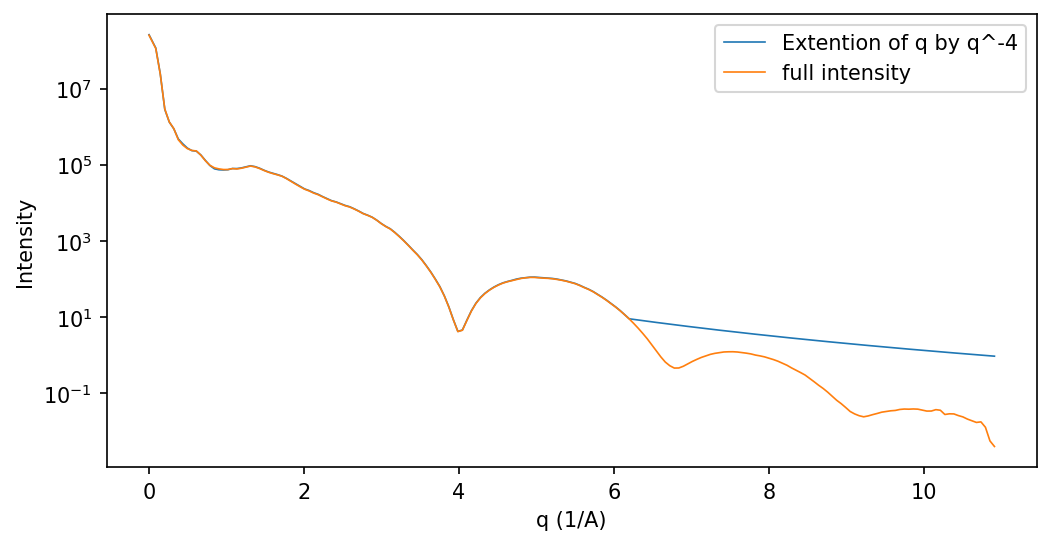

In [847]:
## Try out different ways of data fitting
rho_apo_ = np.fft.fftn(rho_apo)
rho_ligand_ = np.fft.fftn(rho_ligand)

I3D_full_ = np.abs(rho_apo_ + rho_ligand) ** 2
Imean_full_ = saxstats.mybinmean(I3D_full_, qbin_labels, DENSS_GPU)

plt.figure(figsize=(8,4), dpi=150)
plt.plot(qdata, Idata, lw=0.8, label='Extention of q by q^-4')
plt.plot(qdata, Imean_full_[qba], lw=0.8, label='full intensity')
# plt.plot(qdata, Imean_apo_[qba] + Imean_ligand_[qba] + Imean_cross_[qba], lw=0.8, label='I_apo + I_ligand + 2 Re(F_apo * F_ligand)')
# plt.plot(qdata, Imean_apo_[qba] + Imean_ligand_[qba] + Imean_cross_w_[qba], lw=0.8, label='I_apo + I_ligand + 2 abs(F_apo * F_ligand)')
# plt.xlim([-0.1, np.max(q)])
plt.yscale('log')
plt.legend()
plt.xlabel('q (1/A)')
plt.ylabel('Intensity')


In [13]:
rho_apo_ = np.fft.fftn(rho_apo)
I3D_apo_ = np.abs(rho_apo_)**2

In [14]:
rho_ligand_ = np.fft.fftn(rho_ligand)
I3D_ligand_ = np.abs(rho_ligand_)**2

In [15]:
rho_all_ = rho_apo_ + rho_ligand_
I3D_all_ = np.abs(rho_all_)**2

In [16]:
Imean_apo_ = saxstats.mybinmean(I3D_apo_, qbin_labels, DENSS_GPU)

In [17]:
Imean_ligand_ = saxstats.mybinmean(I3D_ligand_, qbin_labels, DENSS_GPU)

In [18]:
Imean_all_ = saxstats.mybinmean(I3D_all_, qbin_labels, DENSS_GPU)

561329.9107729748


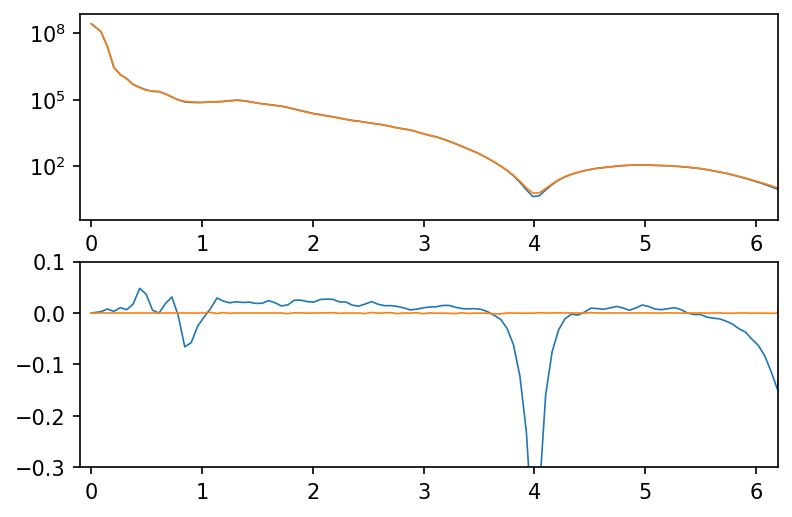

In [522]:
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2

Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])
# plt.yscale('log')
print(np.sum(Idata - Imean_guess_[qba]))

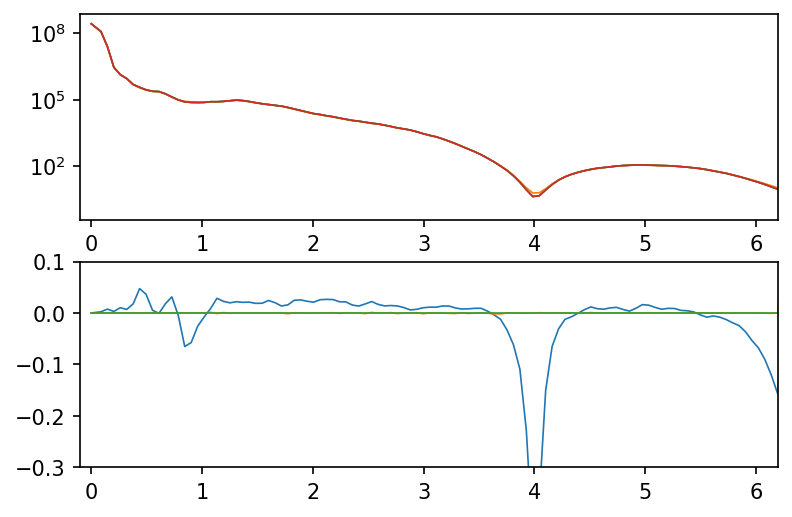

In [525]:
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])


factors = np.sqrt(Idata / Imean_guess_[qba])
rho_guess_all_ = (rho_guess_ + rho_apo_) * factors[qbin_labels]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_all_[qba], lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)


rho_guess_mod_ = rho_guess_ * factors[qbin_labels]
rho_guess_mod_ += rho_apo_ * (factors[qbin_labels] - 1)
rho_apo_mod_ = rho_apo_
I3D_guess_mod_ = np.abs(rho_guess_mod_)**2
I3D_apo_mod_ = np.abs(rho_apo_mod_)**2
Imean_guess_mod_ = saxstats.mybinmean(I3D_guess_mod_, qbin_labels, DENSS_GPU)
Imean_apo_mod_ = saxstats.mybinmean(I3D_apo_mod_, qbin_labels, DENSS_GPU)
I3D_cross_mod_ = 2 * (rho_apo_mod_ * rho_guess_mod_.conjugate()).real
Imean_cross_mod_ = saxstats.mybinmean(I3D_cross_mod_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_mod_[qba] + Imean_apo_mod_[qba] + Imean_cross_mod_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_mod_[qba] - Imean_apo_mod_[qba] - Imean_cross_mod_[qba])/Idata[qba], lw=0.8)

In [23]:
rho_prime = np.fft.ifftn(rho_guess_mod_)
saxstats.write_mrc(rho_prime.real, side, 'test_back.mrc')

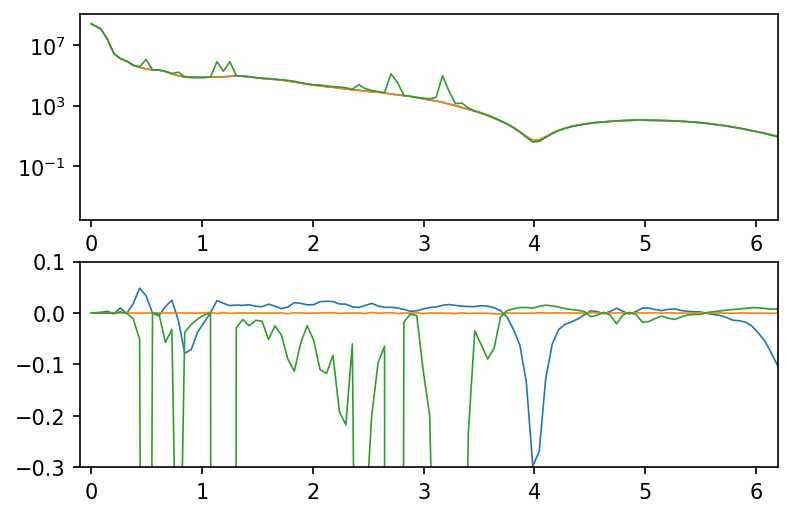

In [21]:
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])


factors = (Idata - Imean_apo_[qba]) / (Imean_guess_[qba] - Imean_apo_[qba])
# factors = (np.sqrt(Idata) - np.sqrt(Imean_apo_[qba])) / (np.sqrt(Imean_guess_[qba]) - np.sqrt(Imean_apo_[qba]))
# factors = np.sqrt(Idata / Imean_guess_[qba])
rho_guess_ *= factors[qbin_labels]# * lig_ne / apo_ne
rho_guess_all_ = (rho_guess_ + rho_apo_)
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_all_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_apo_[qba])/Idata[qba], lw=0.8)


In [22]:
def raster_unit_sphere(num=200):
    L = np.sqrt(num * np.pi);
    pt = []
    for i in range(num):
        h = 1.0 - (2.0 * i + 1.0) / num
        p = np.arccos(h)
        t = L * p
        xu = np.sin(p) * np.cos(t)
        yu = np.sin(p) * np.sin(t)
        zu = np.cos(p)
        pt.append([xu, yu, zu])

    return np.array(pt)


In [23]:
def mypadbinsum(x, bins, nbins, DENSS_GPU=False):
    xsum = np.bincount(bins.ravel(), x.ravel())
    #xcount = cp.bincount(bins.ravel())
    xret = np.empty(nbins)
    xret[:] = np.nan
    #print(f'bins max {bins.max()}, len xsum {len(xsum)}, nbins {nbins}')
    xret[int(bins.max())+1-len(xsum):int(bins.max())+1] = xsum
    return xret


In [24]:
# Determine patches
num_patch = 26
qpatch_labels = np.zeros_like(qbin_labels)
qxyz = np.array([qx.flatten(), qy.flatten(), qz.flatten()]).T
unitr = raster_unit_sphere(num_patch)
#print(unitr)
closest_patch = np.argmax(qxyz @ unitr.T, axis=1).reshape(rho_apo.shape)




/opt/anaconda3/envs/UB/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/UB/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


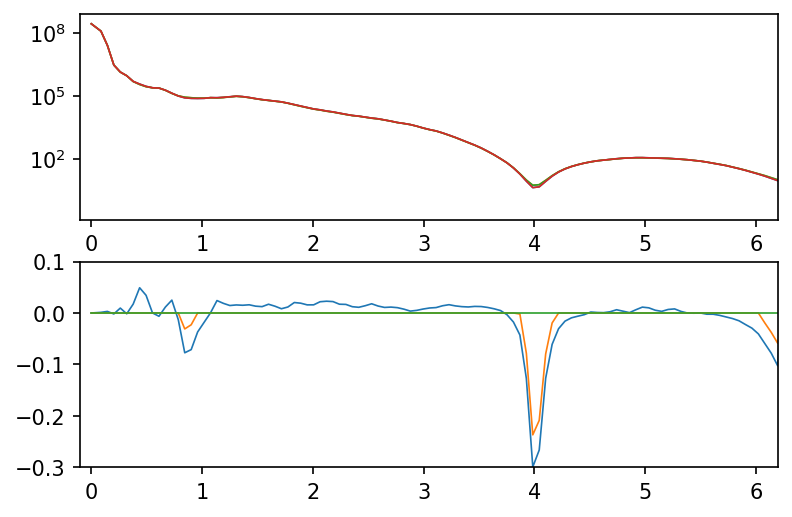

In [34]:
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])


# Calculate binned mean of that patch
patch_n = 10
Isum_this = mypadbinsum(I3D_guess_[closest_patch==patch_n], qbin_labels[closest_patch==patch_n], nbins+1, DENSS_GPU=DENSS_GPU)
# Calculate binned mean of !that patch
Isum_rest = mypadbinsum(I3D_guess_[closest_patch!=patch_n], qbin_labels[closest_patch!=patch_n], nbins+1, DENSS_GPU=DENSS_GPU)

Idata3D = Idata[qbin_labels]
Isum_data = mypadbinsum(Idata3D, qbin_labels, nbins+1, DENSS_GPU=DENSS_GPU)

#print(Imean_this.shape, Imean_rest.shape, Idata.shape)
# Calculate scaling factor of that patch, to (Idata - mean(!that patch))
factors_this = np.sqrt((Isum_data - Isum_rest)/Isum_this) #FIXME: Get the scaling right
# Limit to a preset limit of 0.2 - 5
factors_this[Isum_data <= Isum_rest] = 0.2
factors_this[np.isnan(factors_this)] = 1
factors_this[factors_this < 0.2] = 0.2
factors_this[factors_this > 5] = 5
#factors_this = factors_this[qbin_labels.ravel()] * F_mask.ravel() + (1 - F_mask.ravel())
# print(factors_this)

# Multiply that patch with this scaling factor
rho_guess_all_ = (rho_guess_ + rho_apo_)
rho_guess_all_[closest_patch==patch_n] *= factors_this[qbin_labels][closest_patch==patch_n]
#F.ravel()[closest_patch==patch_n] *= factors_this.ravel()[closest_patch==patch_n]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU=DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)


factors = np.sqrt(Idata / Imean_guess_all_[qba])
rho_guess_all_ = rho_guess_all_ * factors[qbin_labels]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_all_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)



In [39]:
rho_guess_all = np.fft.ifftn(rho_guess_all_).real
rho_guess_all -= rho_apo
rho_guess_all[~lig_mask] = 0
rho_guess_all[rho_guess_all < 0] = 0

In [40]:
saxstats.write_mrc(rho_guess_all, side, 'test_one_step.mrc')

In [41]:
# Try getting the gradient right

In [61]:
# Get where changable voxels are
R = np.array([x.flatten(), y.flatten(), z.flatten()]).T
R = R[lig_mask.flatten()]
R_idx = np.where(lig_mask.flatten())[0]
print(R_idx)

[5432927 5432928 5432929 ... 6600831 6600832 6600833]


(-0.3, 0.1)

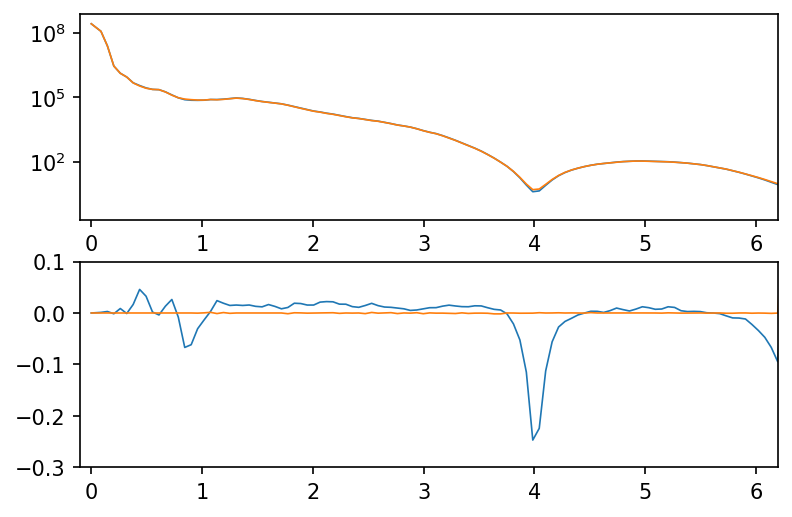

In [138]:
# Get I_calc
rho_guess = rho_ligand.copy()
rho_guess += np.random.random(rho_guess.shape) * 0.3

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne * 1

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])

In [139]:
# Get a uniform sphere
num_J = 1200
Q = raster_unit_sphere(num_J)

In [140]:
d = rho_guess.flatten()[R_idx]
RQ = R @ Q.T

In [194]:
# Write gradient down
R = np.array([x.flatten(), y.flatten(), z.flatten()]).T
R = R[lig_mask.flatten()]
R_idx = np.where(lig_mask.flatten())[0]

num_J = 1200
Q = raster_unit_sphere(num_J)
RQ = R @ Q.T
rho_guess = rho_ligand.copy()
rho_guess += np.random.random(rho_guess.shape) * 0.3

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne


qROI = np.array(range(0, 100))

rho_guess_ = np.fft.fftn(rho_guess)
rho_guess_[rho_guess_==0] = 1e-16
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)


chi_r = saxstats.mysum(((Imean_guess_[qba][qROI]-Idata[qba][qROI])/sigqdata[qba][qROI])**2, DENSS_GPU=DENSS_GPU)/Idata[qba][qROI].size
chi = saxstats.mysum(((Imean_guess_[qba]-Idata[qba])/sigqdata[qba])**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
print(f'Initial: {chi_r:.3f} {chi:.3f}', end='\t\t')

p = rho_apo.flatten()[R_idx]


for step in range(1):

    rho_guess_out = rho_guess / dV
    saxstats.write_mrc(rho_guess_out, side, f'rho_guess_step{step}.mrc')
    
    d = rho_guess.flatten()[R_idx] + p
    G_d = np.zeros((len(R)))
    
    for idx in qROI:
        q_pt = q[idx]
        print(idx, end=' ')
        A = np.cos(q_pt * RQ) # (N, num_J)
        B = np.sin(q_pt * RQ)
        G_d_pt = d.T @ A @ A.T + d.T @ B @ B.T
        G_d_pt *= (Imean_guess_[idx] - Idata[idx])
        G_d_pt *= (4 / num_J / sigqdata[idx] / sigqdata[idx])
        G_d += G_d_pt
    print()
        
    rho_guess_mod = rho_guess.copy().flatten()
    rho_guess_mod[R_idx] -= G_d * 0.1
    rho_guess_mod[rho_guess_mod < 0] = 0
    rho_guess_mod /= np.sum(rho_guess_mod)
    rho_guess_mod *= lig_ne
    
    rho_guess_mod = rho_guess_mod.reshape(rho_guess.shape)

    rho_guess_mod_ = np.fft.fftn(rho_guess_mod)
    rho_guess_mod_[rho_guess_mod_==0] = 1e-16
    I3D_guess_mod_ = np.abs(rho_apo_ + rho_guess_mod_)**2
    Imean_guess_mod_ = saxstats.mybinmean(I3D_guess_mod_, qbin_labels, DENSS_GPU)

    rho_guess = rho_guess_mod.copy()

    Imean_guess_ = Imean_guess_mod_.copy()
    
    chi_r = saxstats.mysum(((Imean_guess_mod_[qba][qROI]-Idata[qba][qROI])/sigqdata[qba][qROI])**2, DENSS_GPU=DENSS_GPU)/Idata[qba][qROI].size
    chi = saxstats.mysum(((Imean_guess_mod_[qba]-Idata[qba])/sigqdata[qba])**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
    print(f'Step {step}: {chi_r:.3f} {chi:.3f}', end='\t\t')
    #     print(G_d_pt)
#     print(G_d)
else:
    rho_guess_out = rho_guess / dV
    saxstats.write_mrc(rho_guess_out, side, f'rho_guess_step{step+1}.mrc')

Initial: 3.791 28.107		0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
Step 0: 12773.648 6810.673		

(-0.3, 0.1)

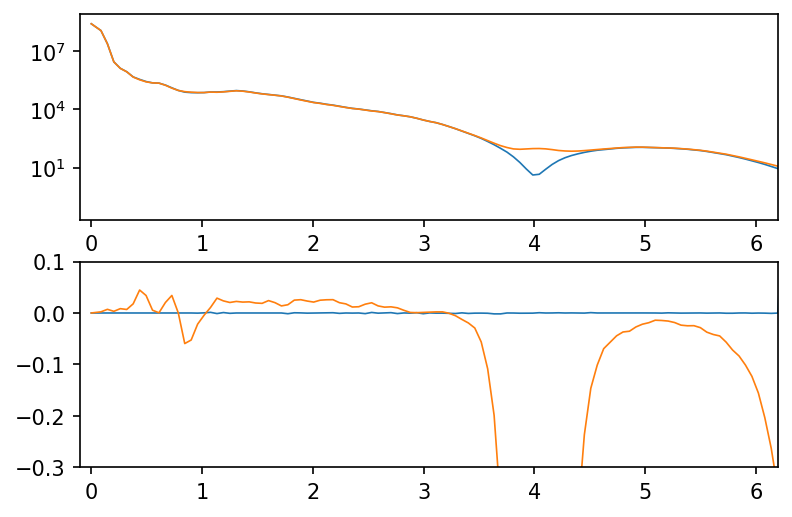

In [196]:
fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])

In [197]:
np.log(10)

2.302585092994046

In [247]:
# Write gradient down - log form
rho_apo, side = saxstats.read_mrc('2cm7_apo.mrc')
rho_guess, side = saxstats.read_mrc('junk.mrc')
rho_apo *= dV
rho_guess *= dV
rho_apo_ = np.fft.fftn(rho_apo)

R = np.array([x.flatten(), y.flatten(), z.flatten()]).T
R = R[lig_mask.flatten()]
R_idx = np.where(lig_mask.flatten())[0]

num_J = 1200
Q = raster_unit_sphere(num_J)
RQ = R @ Q.T
# rho_guess = rho_ligand.copy()
# rho_guess += np.random.random(rho_guess.shape) * 0.3

rho_guess[rho_guess < 0] = 0
rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne


qROI = np.array(range(0, 105))

rho_guess_ = np.fft.fftn(rho_guess)
rho_guess_[rho_guess_==0] = 1e-16
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)
Imean_guess_init_ = Imean_guess_.copy()

chi_r = saxstats.mysum(((np.log10(Imean_guess_[qba][qROI])-np.log10(Idata[qba][qROI]))/ \
                        sigqdata[qba][qROI] * Idata[qba][qROI] * np.log(10))**2, DENSS_GPU=DENSS_GPU)/Idata[qba][qROI].size
chi = saxstats.mysum(((np.log10(Imean_guess_[qba])-np.log10(Idata[qba]))/ \
                      sigqdata[qba] * Idata[qba] * np.log(10))**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
print(f'Initial: {chi_r:.3f} {chi:.3f}', end='\t\t')

p = rho_apo.flatten()[R_idx]


for step in range(50):

    rho_guess_out = rho_guess / dV
    saxstats.write_mrc(rho_guess_out, side, f'rho_guess_step{step}.mrc')
    
    d = rho_guess.flatten()[R_idx] + p
    G_d = np.zeros((len(R)))
    
    for idx in qROI:
        q_pt = q[idx]
        print(idx, end=' ')
        A = np.cos(q_pt * RQ) # (N, num_J)
        B = np.sin(q_pt * RQ)
        G_d_pt = d.T @ A @ A.T + d.T @ B @ B.T
        G_d_pt *= (np.log10(Imean_guess_[idx]) - np.log10(Idata[idx]))
        G_d_pt *= (4 / num_J / sigqdata[idx] / sigqdata[idx] * Idata[idx] * Idata[idx] / Imean_guess_[idx])
        G_d += G_d_pt
    print()
        
    rho_guess_mod = rho_guess.copy().flatten()
    rho_guess_mod[R_idx] -= G_d * 0.0001
    rho_guess_mod[rho_guess_mod < 0] = 0
    rho_guess_mod /= np.sum(rho_guess_mod)
    rho_guess_mod *= lig_ne
    
    rho_guess_mod = rho_guess_mod.reshape(rho_guess.shape)

    rho_guess_mod_ = np.fft.fftn(rho_guess_mod)
    rho_guess_mod_[rho_guess_mod_==0] = 1e-16
    I3D_guess_mod_ = np.abs(rho_apo_ + rho_guess_mod_)**2
    Imean_guess_mod_ = saxstats.mybinmean(I3D_guess_mod_, qbin_labels, DENSS_GPU)

    rho_guess = rho_guess_mod.copy()

    Imean_guess_ = Imean_guess_mod_.copy()
    
    chi_r = saxstats.mysum(((np.log10(Imean_guess_[qba][qROI])-np.log10(Idata[qba][qROI]))/ \
                            sigqdata[qba][qROI] * Idata[qba][qROI] * np.log(10))**2, DENSS_GPU=DENSS_GPU)/Idata[qba][qROI].size
    chi = saxstats.mysum(((np.log10(Imean_guess_[qba])-np.log10(Idata[qba]))/ \
                          sigqdata[qba] * Idata[qba] * np.log(10))**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
    print(f'Step {step}: {chi_r:.3f} {chi:.3f}', end='\t\t')
    #     print(G_d_pt)
#     print(G_d)
else:
    rho_guess_out = rho_guess / dV
    saxstats.write_mrc(rho_guess_out, side, f'rho_guess_step{step+1}.mrc')

Initial: 0.001 0.003		0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 
Step 0: 0.000 0.003		0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 
Step 1: 0.000 0.003		0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 
Ste

KeyboardInterrupt: 

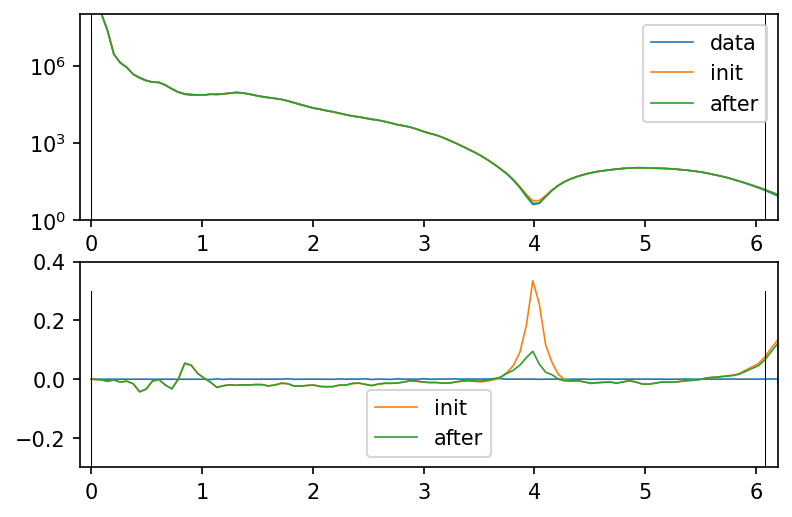

In [245]:
fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8, label='data')
ax[0].plot(qdata[qba], Imean_guess_init[qba], lw=0.8, label='init')
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8,label='after')
ax[0].set_xlim([-0.1, np.max(q)])
ax[0].set_ylim([1, 1e8])
ax[0].legend()
ax[0].set_yscale('log')
ax[0].plot([qdata[qROI[0]], qdata[qROI[0]]], [1, 1e8], 'k', lw=0.5)
ax[0].plot([qdata[qROI[-1]], qdata[qROI[-1]]], [1, 1e8], 'k', lw=0.5)
ax[1].plot(qdata[qba], (Imean_all_[qba] - Idata[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Imean_guess_init_[qba] - Idata[qba])/Idata, lw=0.8,label='init')
ax[1].plot(qdata[qba], (Imean_guess_[qba] - Idata[qba])/Idata, lw=0.8,label='after')
ax[1].plot([qdata[qROI[0]], qdata[qROI[0]]], [-0.3, 0.3], 'k', lw=0.5)
ax[1].plot([qdata[qROI[-1]], qdata[qROI[-1]]], [-0.3, 0.3], 'k', lw=0.5)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.4])
ax[1].legend()

6665.0830124405065
-3.0: 7015236910954701824.000
-2.9: 6125754892853825536.000
-2.8: 5323665814842853376.000
-2.7: 4603048702184649216.000
-2.6: 3958190298273527296.000


KeyboardInterrupt: 

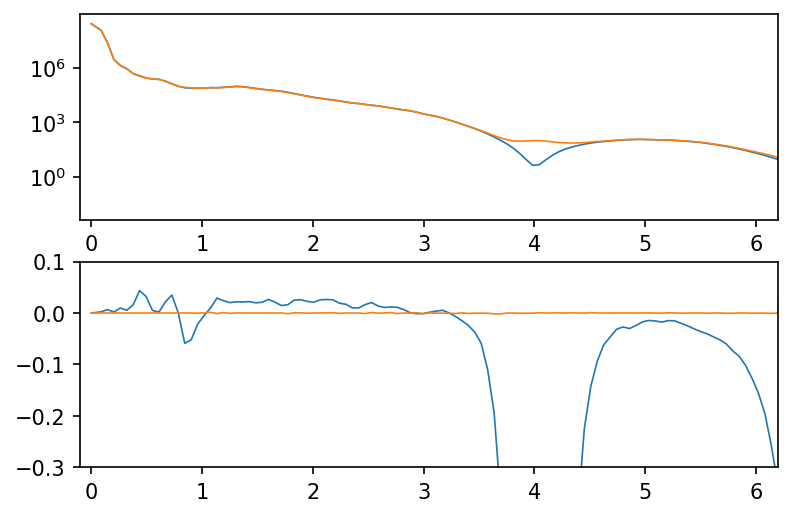

In [193]:
# Get I_calc
# rho_guess = rho_ligand.copy()
# rho_guess += np.random.random(rho_guess.shape) * 0.3

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne * 1

rho_guess_out = rho_guess / dV
# saxstats.write_mrc(rho_guess_out, side, 'rho_guess_3x.mrc')

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

chi = saxstats.mysum(((Imean_guess_[qba]-Idata[qba])/sigqdata[qba])**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
print(chi)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])

for i in np.linspace(-3, 3, num=61):

    rho_guess_mod = rho_guess.copy().flatten()
    rho_guess_mod[R_idx] += G_d * i
    rho_guess_mod = rho_guess_mod.reshape(rho_guess.shape)

    rho_guess_mod_out = rho_guess_mod / dV
    # saxstats.write_mrc(rho_guess_mod_out, side, 'rho_guess_3x_G.mrc')

    rho_guess_mod_ = np.fft.fftn(rho_guess_mod)
    I3D_guess_mod_ = np.abs(rho_apo_ + rho_guess_mod_)**2
    Imean_guess_mod_ = saxstats.mybinmean(I3D_guess_mod_, qbin_labels, DENSS_GPU)
    # ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
    # ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_mod_[qba])/Idata, lw=0.8)

    chi = saxstats.mysum(((Imean_guess_mod_[qba]-Idata[qba])/sigqdata[qba])**2, DENSS_GPU=DENSS_GPU)/Idata[qba].size
    print(f'{i:.1f}: {chi:.3f}')

In [9]:
rho_prime = np.fft.ifftn(rho_apo_ + rho_ligand_)

In [14]:
saxstats.write_mrc((rho_prime - rho_apo).real, side, 'test_back.mrc')

In [422]:
# Let's select an atom and grow it!
lig_S_cen = np.array([8.583,  -1.145,  -4.940])
lig_S_cen = lig_S_cen + np.array([-0.20769767,  0.11081395, -0.16790698])
print(lig_S_cen)

[ 8.16760466 -0.9233721  -5.27581396]


In [423]:
def dist2_from_cen(center, meshx, meshy, meshz):
    return (meshx - center[0])**2 + (meshy - center[1])**2 + (meshz - center[2])**2

In [806]:
def res_func(x, Idata, Iprior, Icross, Iguess, sigqdata):
    return np.sum(((Idata - Iprior - Icross * 2 * np.abs(x) - Iguess * x * x) / sigqdata)**2)

In [681]:
def res_func_log(x, Idata, Iprior, Icross, Iguess, sigqdata):
    return np.max(np.sum(((np.log10(Idata) - np.log10(Iprior + Icross * 2 * np.abs(x) + Iguess * x * x)) / sigqdata)**2), 0)

In [506]:
from scipy.optimize import minimize

In [783]:
minx = np.min(x[lig_mask])
maxx = np.max(x[lig_mask])
miny = np.min(y[lig_mask])
maxy = np.max(y[lig_mask])
minz = np.min(z[lig_mask])
maxz = np.max(z[lig_mask])
print(minx, maxx, miny, maxy, minz, maxz)

4.269767441860473 16.82790697674419 -13.311627906976739 3.7674418604651194 -22.35348837209302 1.2558139534883779


1.5088149068705123 [ 8.37530233 -1.03418605 -5.10790698]
3.0017387004528797
3.002: 0.433 -> 0.366 -> 0.000


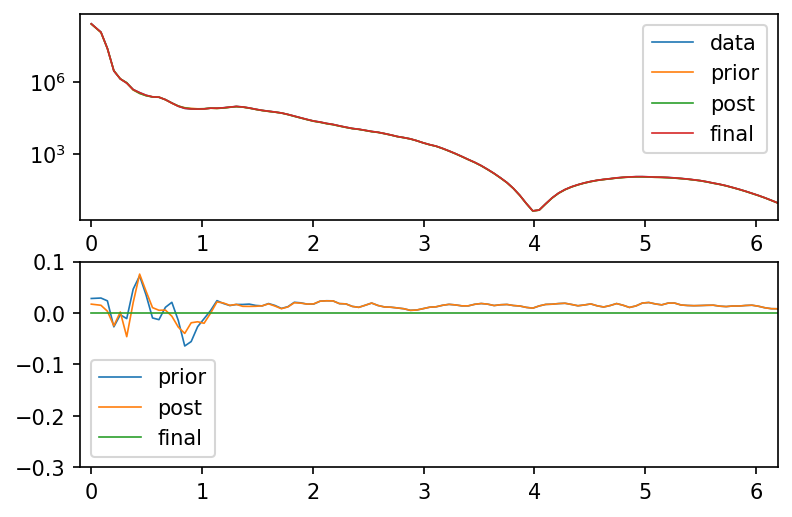

In [820]:
# Sauter method - use dots to paint electron density

rho_lig_S = np.zeros_like(rho_apo)
while rho_lig_S[lig_mask].sum() < 10:
    sigma = np.random.random() * 1.8 + 0.2
    lig_S_cen = np.array([minx + (maxx-minx)*np.random.random(),
                          miny + (maxy-miny)*np.random.random(),
                          minz + (maxz-minz)*np.random.random()])
    lig_S_cen = np.array([8.583,  -1.145,  -4.940])
    lig_S_cen = lig_S_cen + np.array([-0.20769767,  0.11081395, -0.16790698])

    rho_lig_S = 30 / 7.889 / np.sqrt(2 * np.pi)**3 / sigma**3 * np.exp(- dist2_from_cen(lig_S_cen, x, y, z) / 2 / sigma**2)
    if rho_lig_S[lig_mask].sum() < 10:
        print('X', end=' ')
    else:
        print(sigma, lig_S_cen)

        

        
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
# rho_guess += np.random.random(rho_guess.shape) * 0.3
rho_guess += rho_lig_S

# rho_guess[~lig_mask] = 0
# rho_guess /= np.sum(rho_guess)
# rho_guess *= lig_ne

rho_ligand_guess = np.zeros_like(rho_guess)
rho_ligand_guess += np.random.random(rho_guess.shape) * 0.9 + rho_ligand * 0.1
rho_ligand_guess[~lig_mask] = 0
rho_ligand_guess /= np.sum(rho_ligand_guess)
rho_ligand_guess *= lig_ne * 0

rho_prior = rho_apo + rho_ligand_guess
rho_prior_ = np.fft.fftn(rho_prior)
I3D_prior_ = np.abs(rho_prior_)**2
Imean_prior_ = saxstats.mybinmean(I3D_prior_, qbin_labels, DENSS_GPU)

chi_prior = saxstats.mysum(((Imean_prior_[qba]-Idata)/sigqdata)**2, DENSS_GPU=DENSS_GPU)/Idata.size

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

I3D_cross_ = (rho_prior_.conjugate() * rho_guess_).real
Imean_cross_ = saxstats.mybinmean(I3D_cross_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata, Idata, lw=0.8, label='data')
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata, Imean_prior_[qba], lw=0.8, label='prior')
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
# ax[0].set_ylim([1, 10])
ax[1].plot(qdata, (Idata - Imean_prior_[qba])/Idata, lw=0.8, label='prior')
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])

# (-b + sqrt(b^2 - 4ac)) / 2a
# factors = (- 2 * Imean_cross_[qba] + np.sqrt((2 * Imean_cross_[qba])**2 - \
#             4 * Imean_guess_[qba] * (Imean_prior_[qba] - Idata[qba]))) / 2 / Imean_guess_[qba] * Idata[qba] / sigqdata[qba]
# print(factors)
# factors[np.isnan(factors)] = 0
# factors[factors < 0] = 0
# factor = np.sqrt(np.sum(factors) / np.sum(Idata / sigqdata))
# factor = minimize(res_func, 0, (Idata, Imean_prior_[qba], Imean_cross_[qba], Imean_guess_[qba], sigqdata)).x[0]
factor = np.max([minimize(res_func, 0, (Idata, Imean_prior_[qba], Imean_cross_[qba], Imean_guess_[qba], sigqdata)).x[0], 0])
# factor = np.sqrt(np.sum(factors))
print(factor)
rho_guess_mod_ = rho_guess_ * factor


# Multiply that patch with this scaling factor
rho_guess_all_ = (rho_guess_mod_ + rho_prior_)
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
chi_int = saxstats.mysum(((Imean_guess_all_[qba]-Idata)/sigqdata)**2, DENSS_GPU=DENSS_GPU)/Idata.size

ax[0].plot(qdata, Imean_guess_all_[qba], lw=0.8, label='post')
ax[1].plot(qdata, (Idata - Imean_guess_all_[qba])/Idata, lw=0.8, label='post')

rho_guess_all = np.fft.ifftn(rho_guess_all_).real
rho_guess_all -= rho_apo
rho_guess_all[rho_guess_all < 0] = 0
saxstats.write_mrc(rho_guess_all/dV, side, 'rho_guess_all.mrc')

factors = np.ones_like(Imean_guess_all_)
factors[qba] = np.sqrt(Idata / Imean_guess_all_[qba])
rho_guess_all_ = rho_guess_all_ * factors[qbin_labels]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata, Imean_guess_all_[qba], lw=0.8, label='final')
ax[1].plot(qdata, (Idata - Imean_guess_all_[qba])/Idata, lw=0.8, label='final')
chi_now = saxstats.mysum(((Imean_guess_all_[qba]-Idata)/sigqdata)**2, DENSS_GPU=DENSS_GPU)/Idata.size
print(f'{factor:.3f}: {chi_prior:.3f} -> {chi_int:.3f} -> {chi_now:.3f}')
ax[0].legend()
ax[1].legend()



In [718]:
Idata.shape

(107,)

In [321]:
x = np.linspace(0, 10, num=101)

In [322]:
y = np.exp(-40 * (x-5)**2)

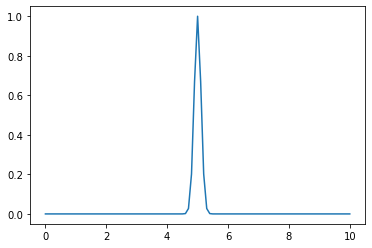

In [323]:
plt.plot(x, y)

In [324]:
y_ = np.fft.fftn(y)
# y_ = np.fft.fftshift(y_)

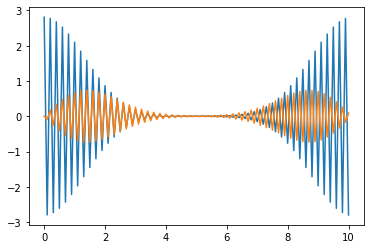

In [325]:
plt.plot(x, y_.real)
plt.plot(x, y_.imag)

In [326]:
y_mod_ = y_ * 1.1
y_mod = np.fft.ifftn(y_mod_)

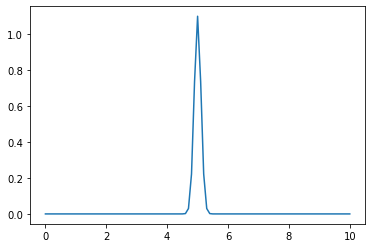

In [329]:
plt.plot(x, y_mod.real)